# 4. STARmap Visual cortex

We also applied SECE to the STARmap data generated from mouse visual cortex. This dataset includes L1, L2/3, L4, L5, L6, as well as the corpus callosum (cc) and hippocampus (HPC) of the visual cortex. The raw data can be doenloaded from http://clarityresourcecenter.org/.

## Load data

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import SECE
import torch
import numpy as np
import scanpy as sc
import random 

result_path = 'visual_cortex'
os.makedirs(result_path, exist_ok=True)

In [2]:
adata = sc.read('./data/visual_cortex.h5ad')

## Creating and training the model

In [3]:
sece = SECE.SECE_model(adata.copy(), 
                       result_path=result_path,
                       dropout_rate=0.1,
                       dropout_gat_rate = 0.2,
                       device='cuda:0')

Likelihood: nb
Input dim: 1020
Latent Dir: 32
Model1 dropout: 0.1
Model2 dropout: 0.2


### AE Module of SECE

In [4]:
sece.prepare_data(lib_size='explog')

Library size: explog
Input normalize: True
Input scale: False
Hvg: False
(1207, 1020)


In [5]:
sece.train_model1(epoch1=80, plot=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.29it/s]


Model1 lr: 0.001
Model1 epoch: 80
Model1 batch_size: 128


In [6]:
adata1 = sece.predict_model1(batch_size=128)

### GAT Module of SECE

In [7]:
sece.prepare_graph(cord_keys=['x','y'], 
                   latent_key = 'X_CE',
                   num_batch_x=1, 
                   num_batch_y=1, 
                   neigh_cal='radius',
                   n_radius=500,
                   kernal_thresh=2)

Batch 1: Each cell have 10.419221209610605 neighbors
Batch 1: Each cell have 4similar cells
All: Each cell have 10.419221209610605 neighbors
Graph cal: radius
radius: 500
kernal_thresh: 2


In [8]:
sece.train_model2(  lr_gat=0.01, 
                    epoch2=40, 
                    re_weight=1, 
                    si_weight=2, 
                    plot=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 33.36it/s]


Model2 lr: 0.01
Model2 epoch: 40
Model2 similar weight: 2


In [9]:
adata1 = sece.predict_model2()

## Spatial domains

### Clustering for spatial domains

In [10]:
sc.pp.neighbors(adata1, use_rep='X_SE', key_added='X_SE')
adata1.obsm['tsne_SE'] = sc.tl.tsne(adata1, use_rep='X_SE', copy=True).obsm['X_tsne']
adata1.obsm['umap_SE'] = sc.tl.umap(adata1, neighbors_key='X_SE', copy=True).obsm['X_umap']

In [11]:
SECE.cluster_func(adata1, clustering='mclust', use_rep='X_SE', cluster_num=7, key_add='cluster')

VSCode R Session Watcher requires jsonlite, rlang. Please install manually in order to use VSCode-R.
R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 5.4.10
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


AnnData object with n_obs × n_vars = 1207 × 1020
    obs: 'y', 'x', 'layer', 'type_raw', 'type_coarsen', 'size', 'n_counts', 'cluster'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p', 'X_SE'
    obsm: 'spatial', 'X_CE', 'X_SE', 'tsne_SE', 'umap_SE'
    layers: 'counts', 'expr'
    obsp: 'X_SE_distances', 'X_SE_connectivities'

### metrics

In [12]:
# ASW & ARI
from sklearn.metrics import silhouette_score as asw_score
from sklearn.metrics import adjusted_rand_score as ari_score

ASW_umap = asw_score(adata1.obsm['umap_SE'], adata1.obs['layer'])
ASW = asw_score(adata1.obsm['X_SE'], adata1.obs['layer'])
ARI = ari_score(adata1.obs['layer'], adata1.obs['cluster'])
print(f'ASW_UMAP:{ASW_umap} \nASW:{ASW} \nARI:{ARI}')

ASW_UMAP:0.2470216453075409 
ASW:0.20257970690727234 
ARI:0.6211579474591791


### Visualization

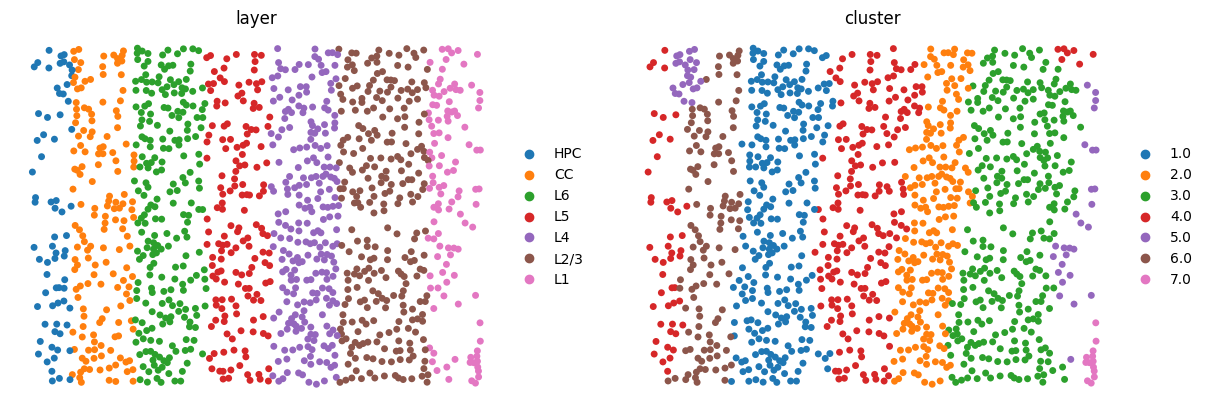

In [13]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context

sc.pl.embedding(adata1, basis='spatial', color=['layer', 'cluster'],
                frameon=False, ncols=2, show=True)


[<AxesSubplot: title={'center': 'layer'}, xlabel='umap_SE1', ylabel='umap_SE2'>,
 <AxesSubplot: title={'center': 'cluster'}, xlabel='umap_SE1', ylabel='umap_SE2'>]

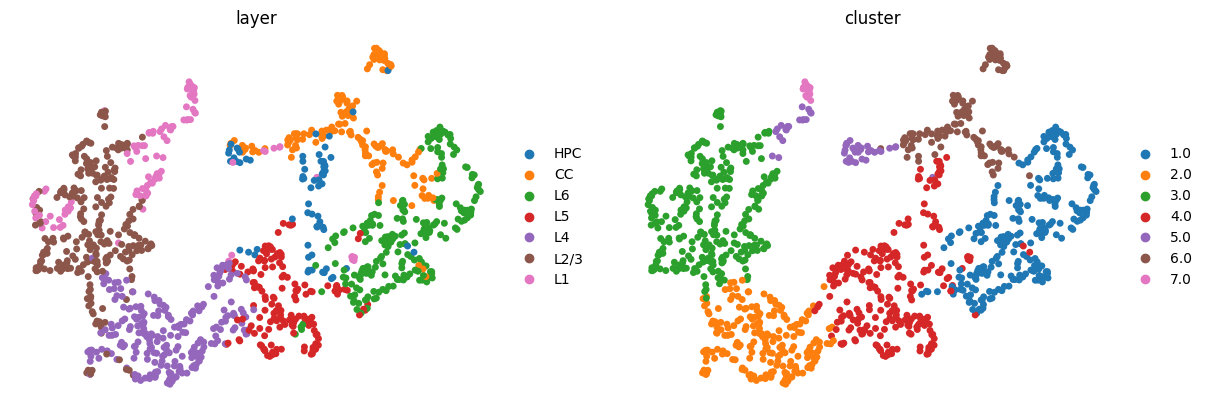

In [14]:
sc.pl.embedding(adata1, basis='umap_SE', color=['layer', 'cluster'],
                frameon=False, ncols=2, show=False)